In [17]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 

import tensorflow as tf 
import keras 
from keras import layers
df = pd.read_csv("../datasets/Task_1/6.csv")
df.head()
X = df.drop(["Price"], axis=1)
y = df["Price"]

In [18]:
correlations = df.corr(numeric_only=True)
correlations

,Price,Levy,Manufacturer,Model,Prod. year,Category,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Airbags
Price,1.00,0.10,-0.03,0.02,0.28,-0.03,0.08,0.01,-0.02,0.03,-0.05,-0.03,-0.10
Levy,0.10,1.00,-0.12,-0.14,0.39,-0.09,0.01,0.15,-0.03,0.27,-0.36,-0.18,0.14
Manufacturer,-0.03,-0.12,1.00,0.37,-0.21,-0.00,0.04,-0.00,0.02,-0.00,0.16,-0.04,-0.00
Model,0.02,-0.14,0.37,1.00,-0.24,0.09,-0.00,0.01,0.00,0.12,0.22,0.03,0.02
Prod. year,0.28,0.39,-0.21,-0.24,1.00,-0.13,-0.06,0.00,-0.06,-0.11,-0.53,-0.12,0.21
Category,-0.03,-0.09,-0.00,0.09,-0.13,1.00,0.08,-0.00,-0.00,-0.10,0.15,0.32,-0.02
Fuel type,0.08,0.01,0.04,-0.00,-0.06,0.08,1.00,0.04,0.02,0.01,0.00,0.04,-0.18
Engine volume,0.01,0.15,-0.00,0.01,0.00,-0.00,0.04,1.00,-0.00,0.11,-0.02,-0.03,0.03
Mileage,-0.02,-0.03,0.02,0.00,-0.06,-0.00,0.02,-0.00,1.00,-0.00,0.04,0.01,-0.01
Cylinders,0.03,0.27,-0.00,0.12,-0.11,-0.10,0.01,0.11,-0.00,1.00,-0.04,-0.23,0.17


In [ ]:
#this doesnt finish for some reason, just runs forever

#from skfeature.function.similarity_based import fisher_score

# get the fisher's score rankings 
#ranks = fisher_score.fisher_score(X.values, y.values)

# create a pandas DataFrame for easier interpretation
#feat_importances = pd.Series(ranks, X.columns)
#feat_importances.plot(kind='barh')

# how to interpret -> low score means the effect of this field is not large in the dataset
# => typically means other columns in the dataset have similar correlations, 
# therefore making this particular column not so useful since other columns 
# already fill this role for this correlation

# Fisher's score studies the variance of the data -> statistical significance'

# based on Fisher's score:
# num_rooms is not important at all, and num_people has minor importance in this data
# but ave_monthly_income is quite powerful based on Fisher's score

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# initialize chi2 and SelectKBest
# Note: chi2 -test is a very common test
# in statistics and quantitative analysis
# basically it studies the data whether variables are related
# or independent of each other
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# use decimal format in table print later
pd.options.display.float_format = '{:.2f}'.format

# wrap it up, and show the results
# the higher the score, the more effect that column has on target variable
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
7,Mileage,1953314051269.59
0,Levy,2323234.07
2,Model,1460548.94
1,Manufacturer,20223.84
11,Airbags,13195.99
4,Category,5707.91
6,Engine volume,5552.52
9,Gear box type,2691.93
5,Fuel type,2401.42
8,Cylinders,1286.30


In [20]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)

# step 2, split the temporary data in HALF (0.5) => 15% test and 15% validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [21]:
# create neural network

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# save the amount of support variables into a helper variable
# so we don't have to update the input_shape all the time
variable_amount = len(X.columns)

# create callbacks and place them into a parameter list
# NOTE! if you get PermissionError while training the model,
# just try training it again
mc = ModelCheckpoint('best_model_regression1_cars.keras', monitor='val_loss', mode='min', save_best_only=True)

# if you use multiple callbacks (EarlyStoppin, ReduceLROnPlateau etc.)
# add them to this same list
callback_list = [mc]

# let's try some common optimization approaches

# neural networks often need at least a normalization layer
# so that it updates all weight values fairly 
# typically the original dataset has various scales of numbers
# which confuses neural network while it's training itself
# luckily we have the BatchNormalization -layer in keras!

# regularization is often beneficial in neural networks
# but it's usually better to apply this a bit later
# once you know approximately a working neural network structure for your data
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(variable_amount,)),
        layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.1)),
        layers.Dropout(0.1),
        layers.Dense(10, activation="relu"),
        layers.Dense(8, activation="relu"),
        layers.Dense(1)
    ]
)

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
model.compile(optimizer='adam', loss='mse')

# common tips on how to change neural network structure if your metrics are not good:
#####################################################################################
# make wider (or narrower) layers (for example, 64 or 128 nodes)
# make a longer or shorter network (add or remove layers)
# use Dropout -layers (e.g. layers.Dropout(0.1))

# remember: there's no process or mathematical formula
# in order to figure out the optimal neural network structure
# it's mostly all about trial and error => EXPERIMENTATION!

# remember to have enough "decision-space" for your data!
# it's highly unlikely a dataset with 20 different variables is going
# to work well with only 8 nodes in each layer etc.

# print out the summary of your model
model.summary()

/home/lukas/dev/venvs/DL/lib/python3.12/site-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523 (2.04 KB)

 Trainable params: 499 (1.95 KB)

 Non-trainable params: 24 (96.00 B)

In [22]:
model.fit(x=X_train, y=y_train, epochs=1200, validation_data=(X_val, y_val), callbacks=callback_list)

Epoch 1/1200
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 509141728.0000 - val_loss: 419178560.0000
Epoch 2/1200
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 281772128.0000 - val_loss: 243652912.0000
Epoch 3/1200
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 227000576.0000 - val_loss: 236409360.0000
Epoch 4/1200
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 220128624.0000 - val_loss: 232489392.0000
Epoch 5/1200
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 216505760.0000 - val_loss: 229566416.0000
Epoch 6/1200
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 213108656.0000 - val_loss: 228264320.0000
Epoch 7/1200
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 213322592.0000 - val_loss: 225027968.0000
Epoch 8/1200
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 210376656.0000 - val_loss: 225533504.0000
Epoch 9/1200
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 210579760.0000 - val_loss: 224383280.0000
Epoch 10/1200
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 890u

<Axes: >

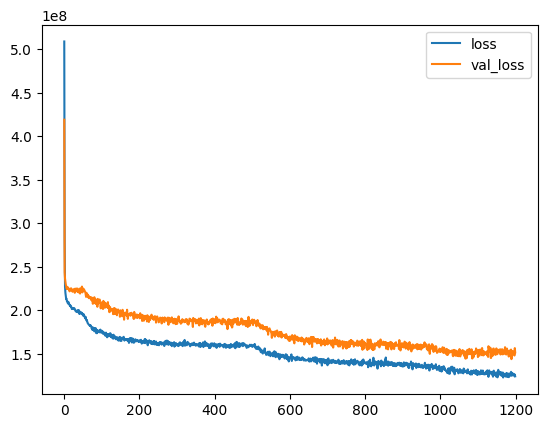

In [23]:
# let's use pandas for this (easy code)
# try to look if the model is actually training 
# => the error is going downwards
# if using validation data, you get two lines
# in this case, see if the lines follow a similar trend 
# (they don't always overlap with complex data, the trend is more important)
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [25]:
from keras.models import load_model
model = load_model("best_model_regression1_cars.keras")

In [26]:
# compare the final model loss/evaluation values
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
403256288.0

Train data evaluation:
2148506624.0


In [27]:
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step


,Test True Y,Model Predictions
0,24681,21141.81
1,9722,13863.75
2,20385,16154.22
3,40769,28460.67
4,9722,13885.39
...,...,...
2587,12529,16963.60
2588,13589,19830.66
2589,282,6046.81
2590,1411,7406.16


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

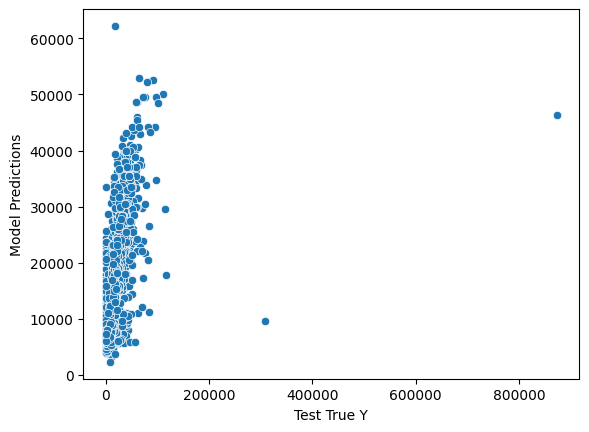

In [28]:
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

In [29]:
# MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
7154.35 $

MSE
403256256.0 $^2

RMSE:
20081.24 $

R-squared:
0.25

Explained variance score:
0.25


/tmp/ipykernel_246970/3124900743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


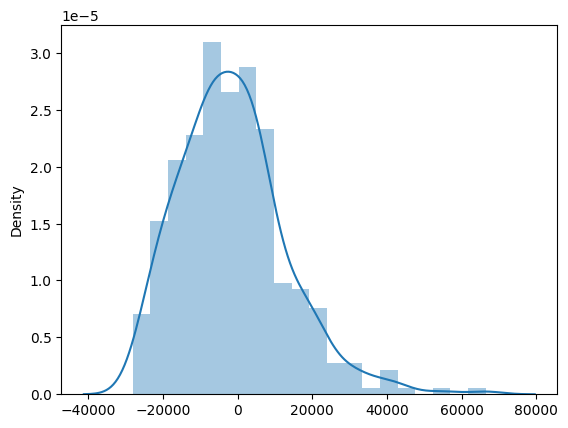

In [16]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()